# GOLA Google Colab Demo

[Open in Colab](https://colab.research.google.com/github/abhyudaymishr/GNOsLA/blob/main/notebooks/gola_colab_demo.ipynb)

This notebook installs `gola` from GitHub, runs a low-memory training step (<8 GB profile), and generates dataset-backed visualizations in Colab.


In [2]:
import sys
import subprocess

subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'git+https://github.com/abhyudaymishr/GNOsLA.git'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'plotly>=5.22'])
print('install complete')

install complete


In [3]:
import sys
from pathlib import Path

import numpy as np
import plotly.io as pio
from IPython.display import IFrame, Image, display

from gola.data import PreGenNavierStokes2DDataset
from gola.model import GOLAOperator
from gola.train import TrainConfig, train_operator
from gola.visualization import DatasetAttentionConfig, save_dataset_sparse_geometric_attention
from gola.visualization_plotly import PlotlyKernelVisualizationConfig, save_plotly_kernel_figure

if 'google.colab' in sys.modules:
    pio.renderers.default = 'colab'

print('imports complete')


imports complete


In [4]:
demo = np.random.randn(2, 4, 64, 64, 3).astype('float32')
demo[:, :, 24:40, 24:40, :2] = 0.0

data_path = Path('/content/gola_demo.npy' if 'google.colab' in sys.modules else 'notebooks/_colab_demo.npy')
data_path.parent.mkdir(parents=True, exist_ok=True)
np.save(data_path, demo)
data_path

PosixPath('/content/gola_demo.npy')

## Low-memory training run (<8 GB profile)

Runs one quick epoch with `low_memory_mode=True` on a synthetic Navier-Stokes-like tensor.


In [5]:
dataset = PreGenNavierStokes2DDataset.from_file(data_path, layout='STHWC', delta_t_steps=1, mmap=True)

model = GOLAOperator(
    in_channels=dataset.channels,
    out_channels=dataset.channels,
    hidden_dim=96,
    num_layers=3,
    spatial_dim=dataset.x.shape[-1],
    residual_output=True,
)

config = TrainConfig(
    epochs=1,
    batch_size=1,
    num_workers=0,
    learning_rate=1e-3,
    weight_decay=1e-6,
    radius=0.05,
    max_neighbors=24,
    graph_chunk_size=256,
    low_memory_mode=True,
    ram_budget_gb=8.0,
    device='cpu',
    log_every=10,
)

history = train_operator(model, dataset, config)
history[-1]


[memory] low_memory_mode enabled | estimated_peak_ram_gb=0.03 | budget_gb=8.00
[epoch 001] loss=1.930522 field=1.930522 div=0.000000 energy=0.000000 enstrophy=0.000000


{'loss': 1.9305217663447063,
 'field': 1.9305217663447063,
 'div': 0.0,
 'energy': 0.0,
 'enstrophy': 0.0}

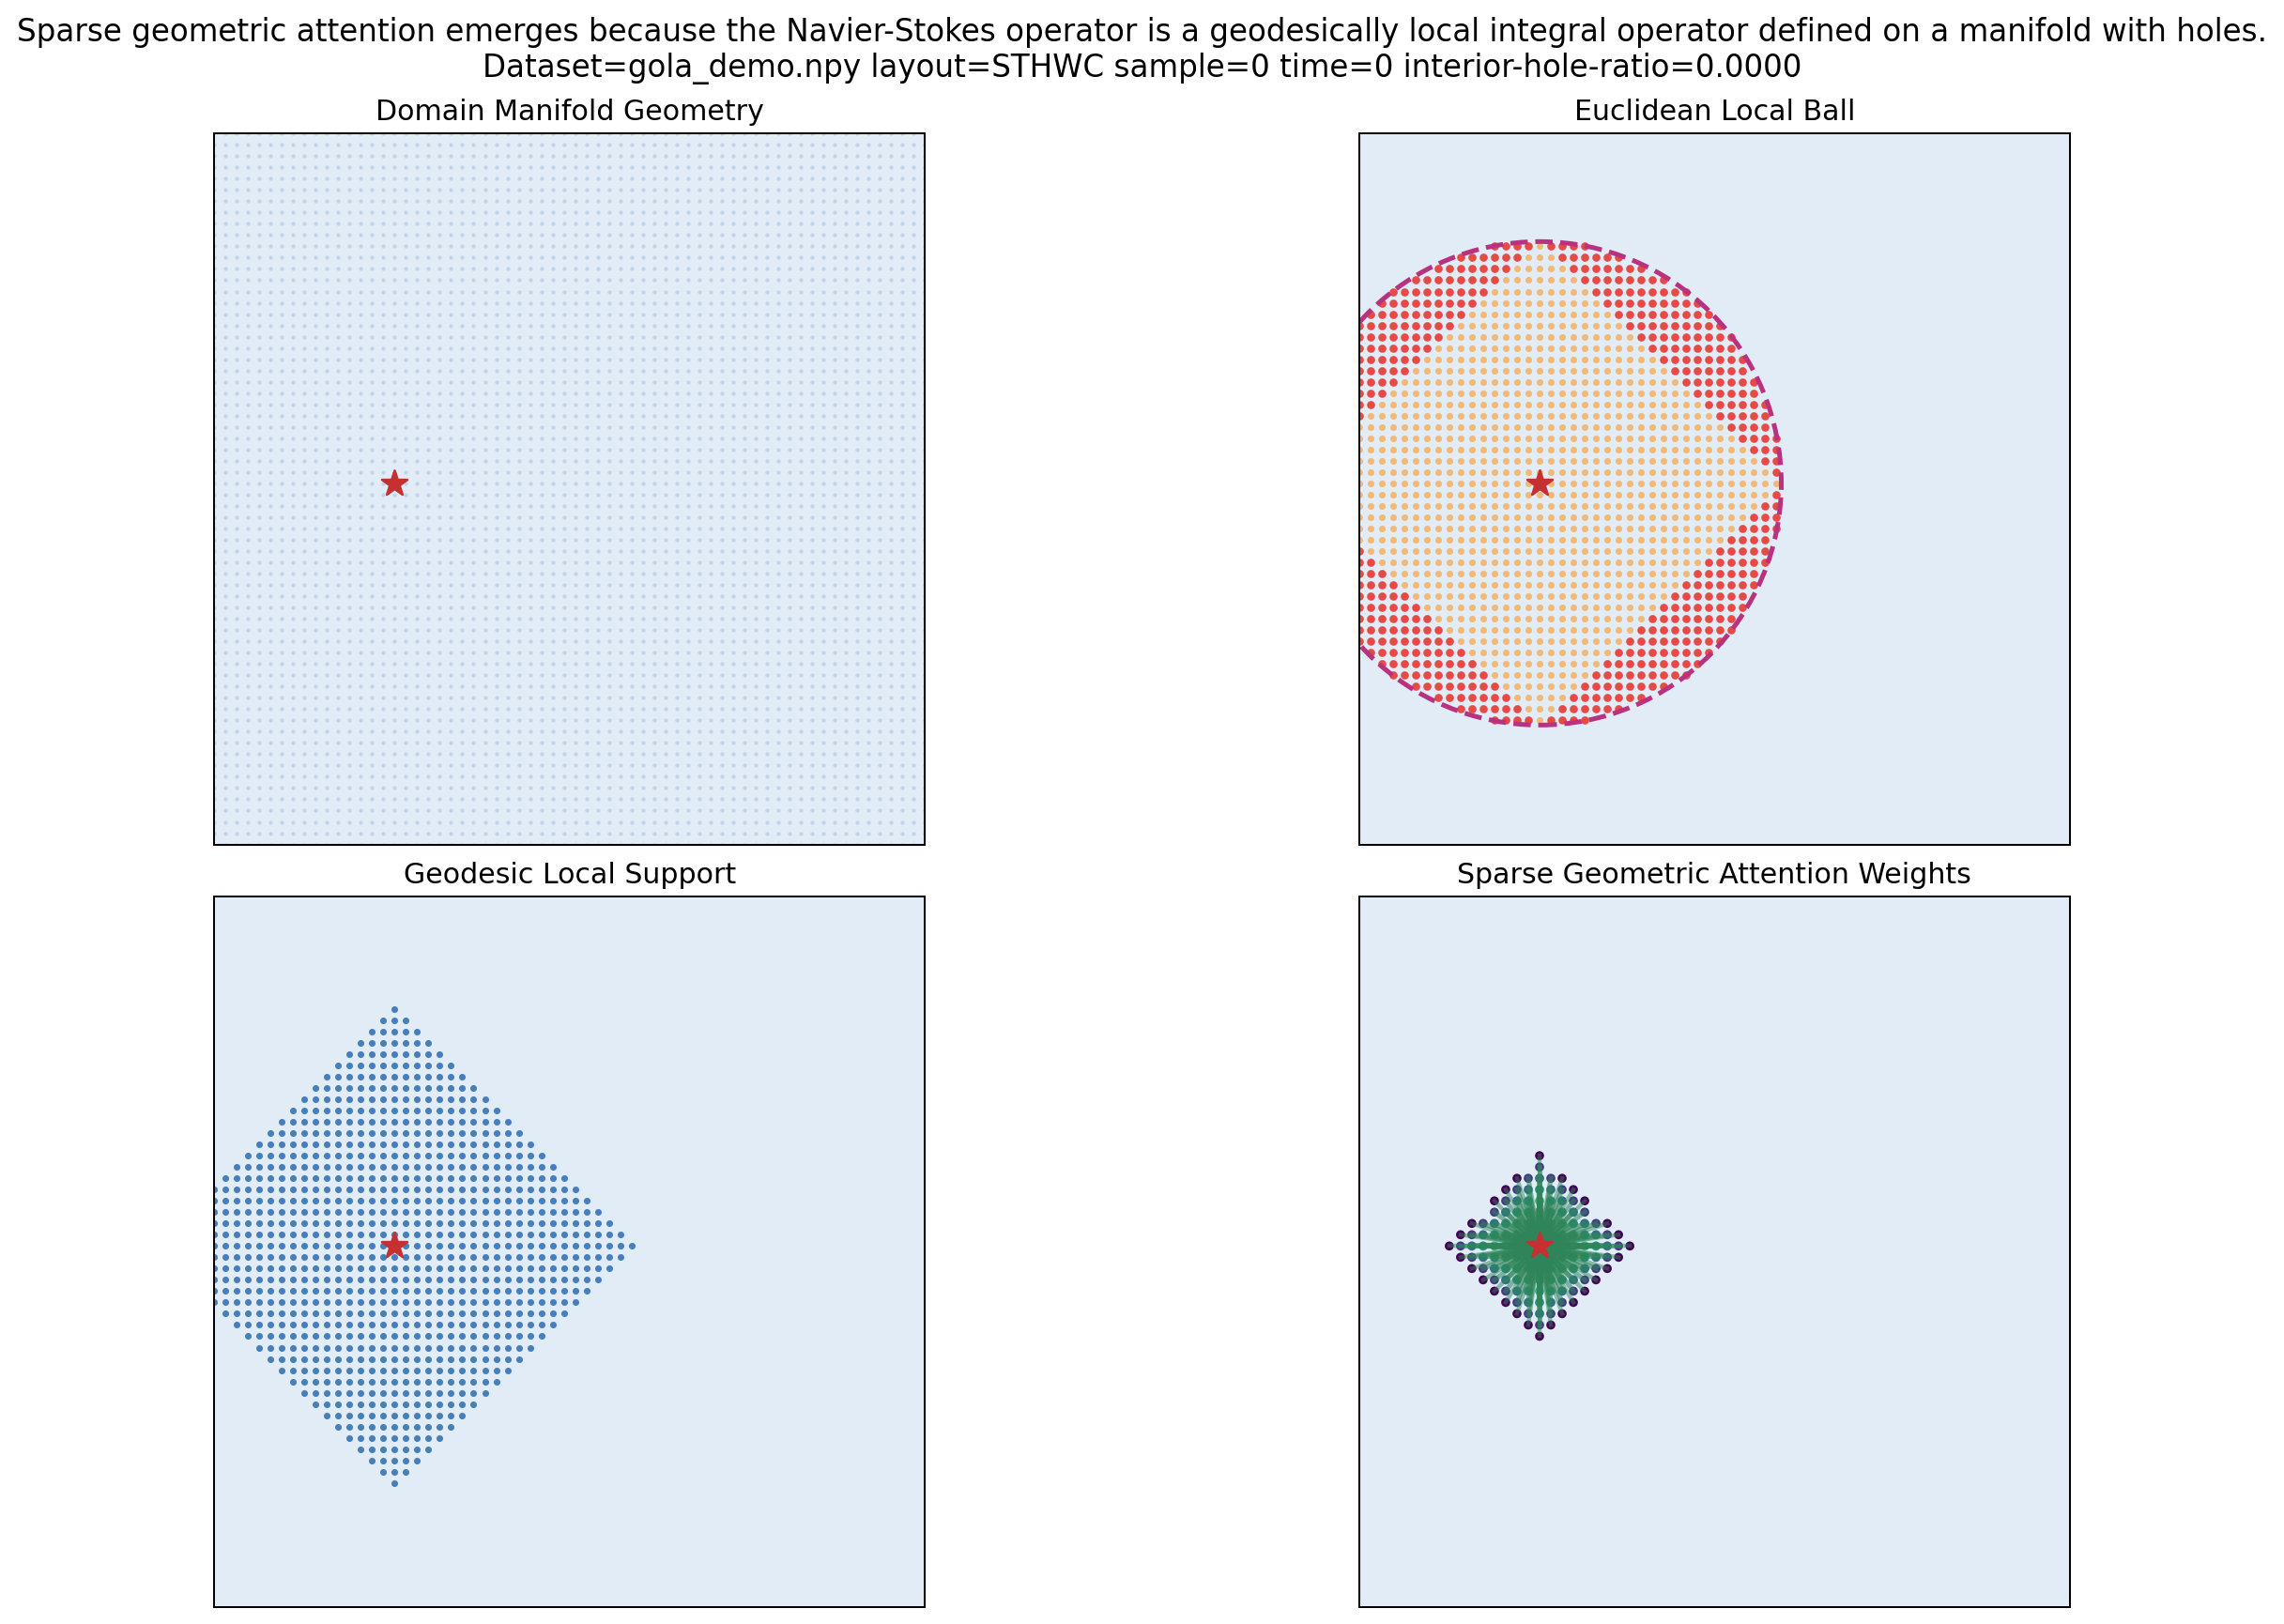

PosixPath('/content/gola_attention_demo.png')

In [6]:
png_out = Path('/content/gola_attention_demo.png' if 'google.colab' in sys.modules else 'notebooks/gola_attention_demo.png')
cfg = DatasetAttentionConfig(data_path=data_path, layout='STHWC', sample_idx=0, time_idx=0)
save_dataset_sparse_geometric_attention(png_out, config=cfg, dpi=180)
display(Image(filename=str(png_out)))
png_out

In [7]:
html_out = Path('/content/gola_kernel_3d_demo.html' if 'google.colab' in sys.modules else 'notebooks/gola_kernel_3d_demo.html')
plotly_cfg = PlotlyKernelVisualizationConfig(
    mode='dataset',
    output_html=html_out,
    dataset=DatasetAttentionConfig(data_path=data_path, layout='STHWC', sample_idx=0, time_idx=0),
    query_x=0.3,
    query_y=0.5,
    random_query=False,
)
save_plotly_kernel_figure(plotly_cfg)
display(IFrame(src=str(html_out), width='100%', height=760))
html_out

PosixPath('/content/gola_kernel_3d_demo.html')

## Hugging Face dataset download (real run, no dry-run)

Downloads the full file `Geometry_Axis/FPO_Geometry_Easy_NoObstacle.npy` (~50 GB).

This cell checks available disk first, then performs a real `hf_hub_download`, opens the array with mmap, and runs a dataset-backed visualization.


In [8]:
from dataclasses import field
from huggingface_hub import hf_hub_download
import os
import shutil

root = '/content' if 'google.colab' in sys.modules else '.'
free_gb = shutil.disk_usage(root).free / (1024**3)
print(f'free_gb={free_gb:.2f}')
if free_gb < 60:
    raise RuntimeError('Need at least 60 GB free for this dataset download.')

hf_file = hf_hub_download(
    repo_id='sage-lab/PreGen-NavierStokes-2D',
    filename='Geometry_Axis/FPO_Geometry_Easy_NoObstacle.npy',
    repo_type='dataset',
)




free_gb=86.43


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



Geometry_Axis/FPO_Geometry_Easy_NoObstac(…):   0%|          | 0.00/50.3G [00:00<?, ?B/s]

hf_file= /root/.cache/huggingface/hub/datasets--sage-lab--PreGen-NavierStokes-2D/snapshots/94de5e6f98ba6b552168c2f238b2a4123a5d3aac/Geometry_Axis/FPO_Geometry_Easy_NoObstacle.npy
size_gb=46.88
shape= (6400, 20, 128, 128, 6) dtype= float32


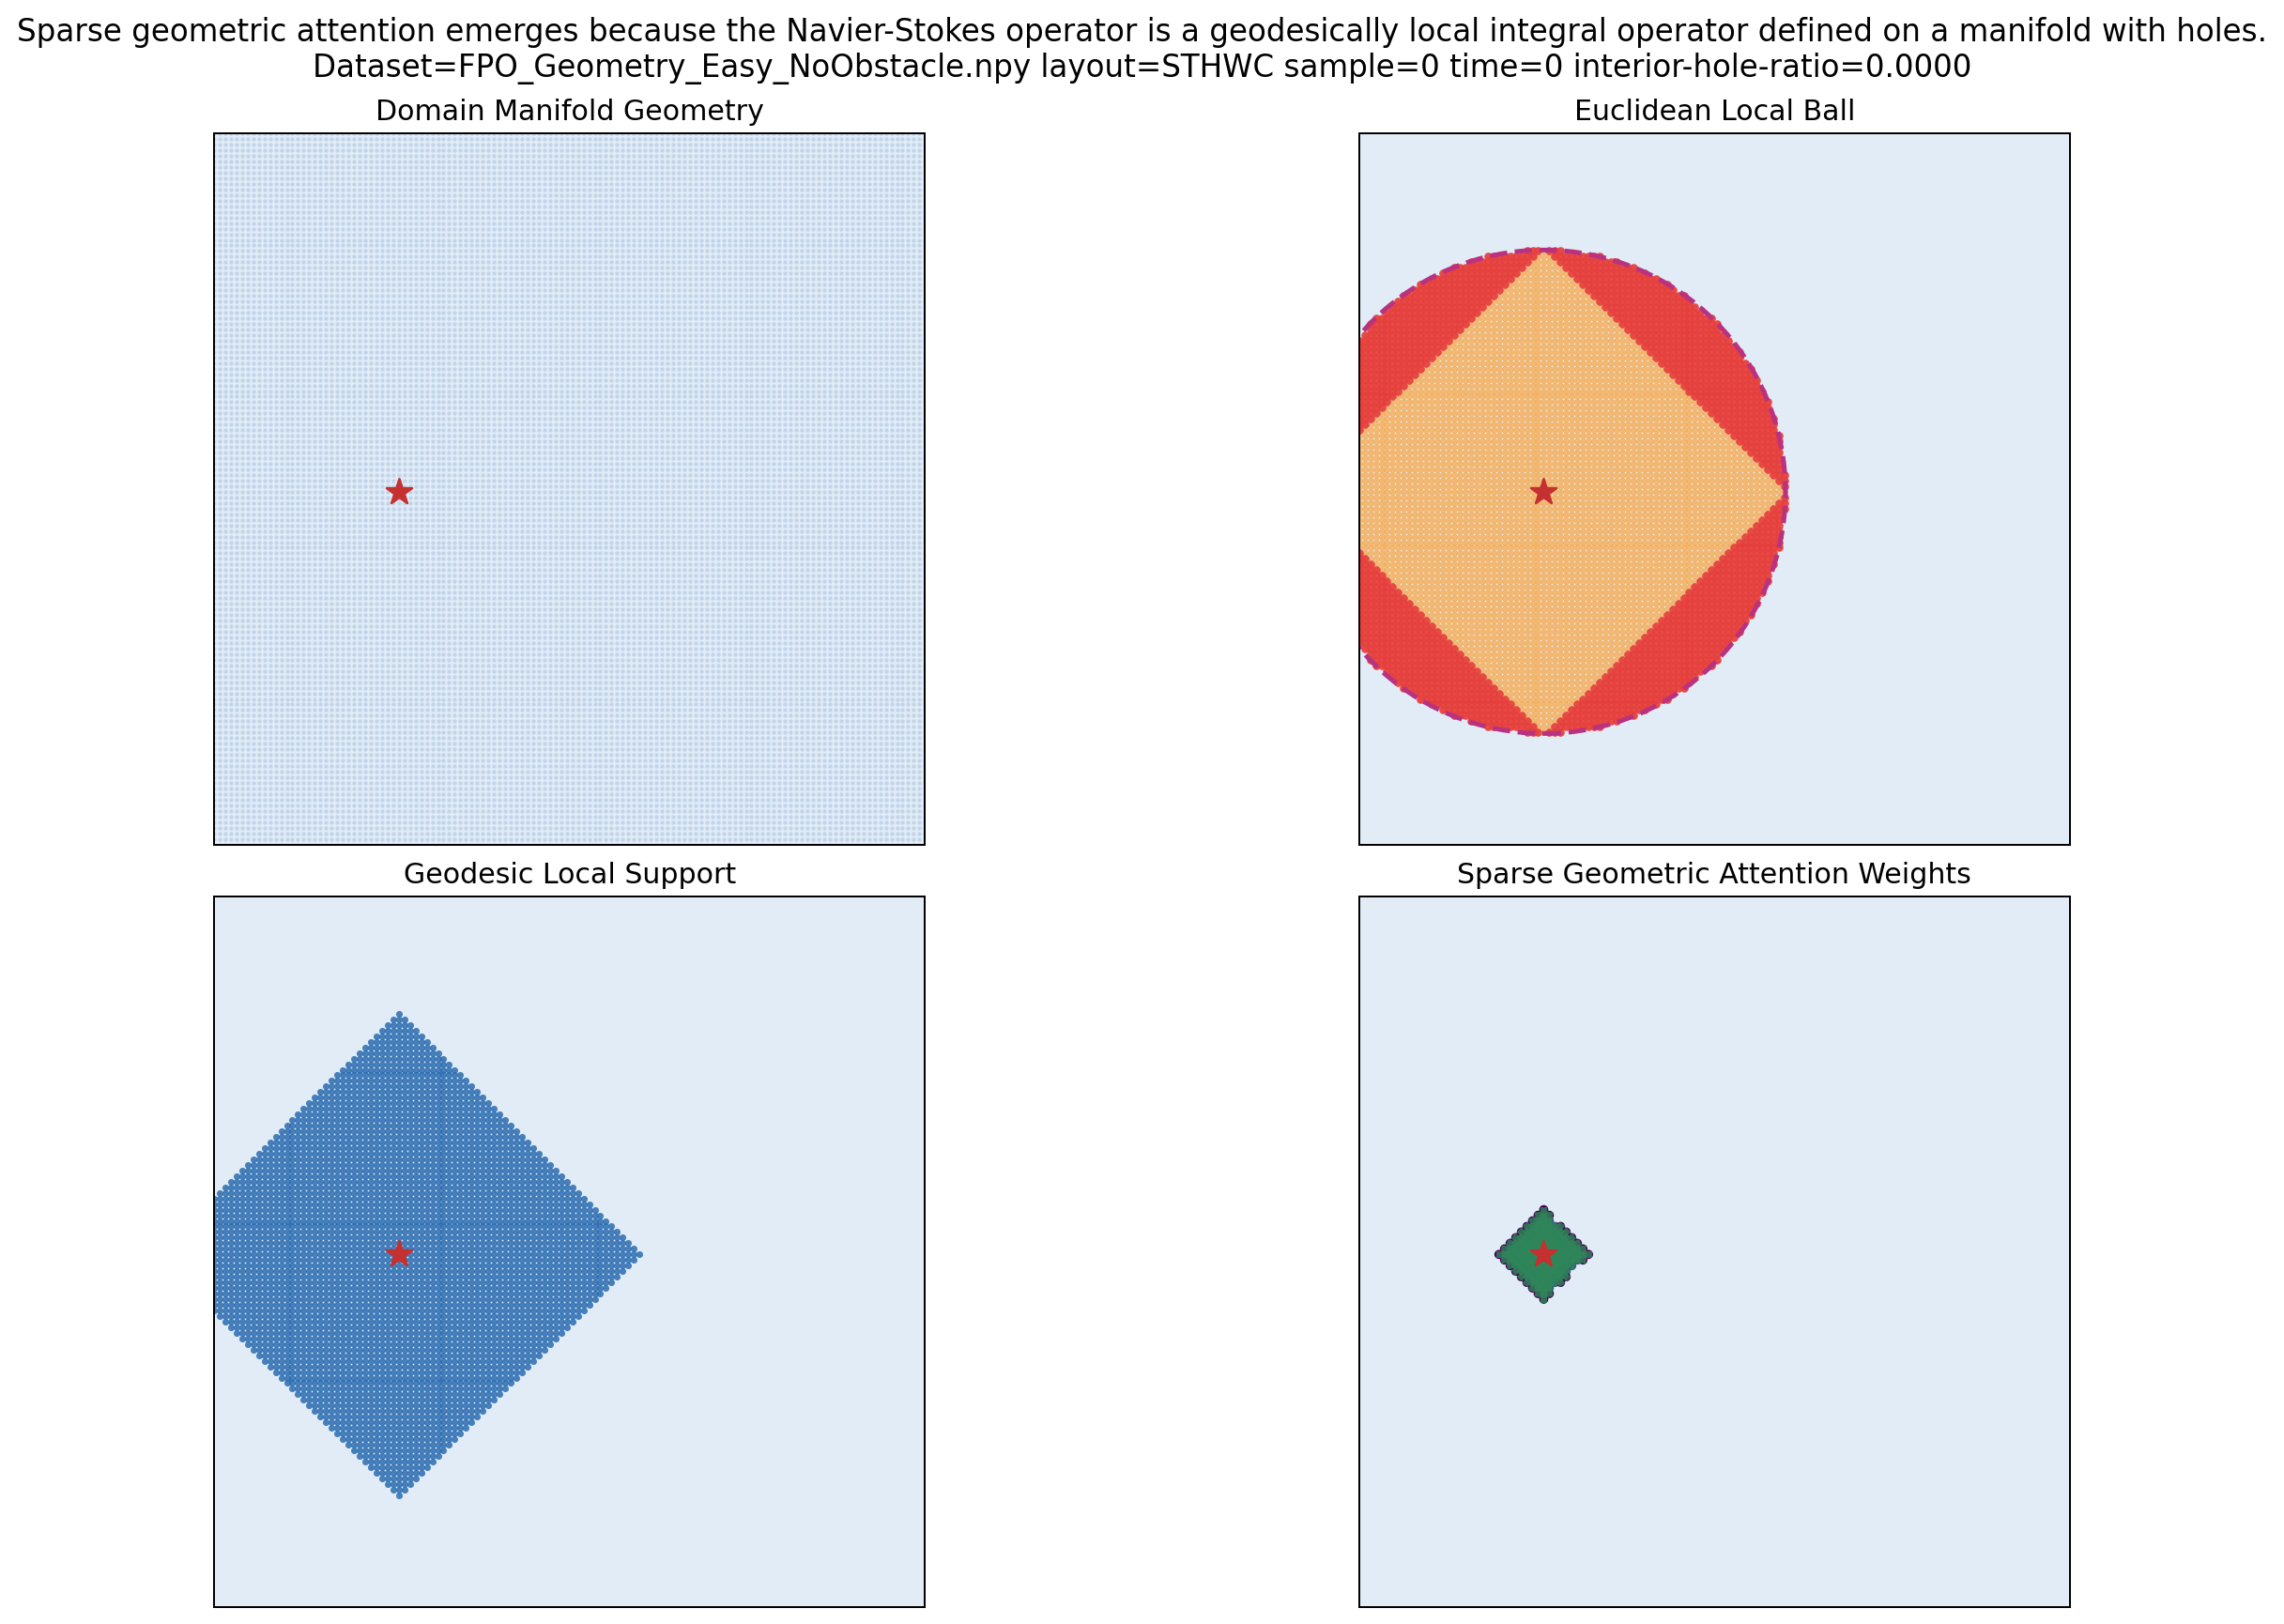

PosixPath('/content/gola_attention_real.png')

In [12]:
size_gb = os.path.getsize(hf_file) / (1024**3)
print('hf_file=', hf_file)
print(f'size_gb={size_gb:.2f}')

arr = np.load(hf_file, mmap_mode='r')
print('shape=', arr.shape, 'dtype=', arr.dtype)

field_png = Path('/content/gola_attention_real.png' if 'google.colab' in sys.modules else 'notebooks/gola_attention_real.png')
real_cfg = DatasetAttentionConfig(data_path=Path(hf_file), layout='auto', sample_idx=0, time_idx=0)
save_dataset_sparse_geometric_attention(field_png, config=real_cfg, dpi=180)
display(Image(filename=str(field_png)))
field_png

In [13]:
real_html = Path('/content/gola_kernel_3d_real.html' if 'google.colab' in sys.modules else 'notebooks/gola_kernel_3d_real.html')
real_plotly_cfg = PlotlyKernelVisualizationConfig(
    mode='dataset',
    output_html=real_html,
    dataset=DatasetAttentionConfig(data_path=Path(hf_file), layout='auto', sample_idx=0, time_idx=0),
    random_query=True,
)
save_plotly_kernel_figure(real_plotly_cfg)
display(IFrame(src=str(real_html), width='100%', height=760))
real_html

PosixPath('/content/gola_kernel_3d_real.html')